In [1]:
import arkouda as ak

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: 0+unknown


In [383]:
# arkouda needs a chapel server. for running this code first have to set up server
ak.connect(connect_url='tcp://localhost:5555')

connected to arkouda server tcp://*:5555


In [327]:
import numpy as np
import pandas as pd

In [331]:
ardf=pd.read_csv("refined_train_data.csv"  )
ardf.head()

,Unnamed: 0,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,quantity,payment_datetime,delivery_date,weight,weight_units,package_size,Distance,pay_to_acctt,del_days
0,0,1,0.0,0,0.0,3,5,6,35.99,1,2019-07-06,2019-07-10,7,1,5,1621.567281,2,4
1,1,2,1.0,1,0.0,2,5,10,349.99,2,2019-01-02,2019-01-07,176,1,5,687.747533,1,5
2,2,1,2.0,1,12.0,2,5,6,102.50,1,2018-11-11,2018-11-19,32,1,5,1057.383292,4,8
3,3,2,5.0,1,10.5,2,5,10,18.44,1,2018-05-02,2018-05-07,0,1,5,2567.202433,2,5
4,4,2,5.0,0,8.4,3,5,3,4.55,1,2019-02-23,2019-03-04,16,1,5,887.293984,5,9


In [332]:
ardf.drop(['Unnamed: 0'], axis=1,inplace=True)

In [10]:
# converting dataframe to arkouda directory for operation on data
def ak_create_akdict_from_df(df):
    akdict ={}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname]= ak.from_series(df[cname])
    return akdict

In [33]:
arkdict = ak_create_akdict_from_df(ardf)

In [34]:
# data converted as arkouda directory
arkdict

{'b2c_c2c': array([1 2 1 ... 2 2 2]),
 'declared_handling_days': array([0 1 2 ... 1 2 1]),
 'shipment_method_id': array([0 1 1 ... 0 0 0]),
 'shipping_fee': array([0 0 12 ... 0 0 0]),
 'carrier_min_estimate': array([3 2 2 ... 3 3 3]),
 'carrier_max_estimate': array([5 5 5 ... 5 5 5]),
 'category_id': array([6 10 6 ... 12 0 11]),
 'item_price': array([35.990000000000002 349.99000000000001 102.5 ... 6.79 11.58 6.9800000000000004]),
 'quantity': array([1 2 1 ... 1 1 1]),
 'payment_datetime': array(['2019-07-06', '2019-01-02', '2018-11-11', ... , '2018-04-05', '2019-10-07', '2019-01-23']),
 'delivery_date': array(['2019-07-10', '2019-01-07', '2018-11-19', ... , '2018-04-09', '2019-10-15', '2019-01-28']),
 'weight': array([7 176 32 ... 4 0 4]),
 'weight_units': array([1 1 1 ... 1 1 1]),
 'package_size': array([5 5 5 ... 5 4 5]),
 'Distance': array([1621.5672809586274 687.74753275666808 1057.3832923390451 ... 2548.721029168873 3866.1171860804561 4271.1202301128842]),
 'pay_to_acctt': array([

In [333]:
# some operations by arkouda to reduce fetures
arkdict['carrier_mean'] = (arkdict['carrier_min_estimate']+arkdict['carrier_max_estimate'])/2

In [334]:
arkdict['whole_weight'] = arkdict['weight']*arkdict['weight_units']

In [335]:
arkdict['total_price'] = arkdict['item_price']*arkdict['quantity']

In [336]:
arkdict['exp_handling'] = arkdict['pay_to_acctt']+arkdict['declared_handling_days']

In [337]:
#back to dataframe from arkouda directory
akdf = pd.DataFrame({col: a.to_ndarray() for col, a in arkdict.items()})



In [338]:
akdf.head()

,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,quantity,payment_datetime,...,weight,weight_units,package_size,Distance,pay_to_acctt,del_days,carrier_mean,whole_weight,total_price,exp_handling
0,1,0.0,0,0.0,3,5,6,35.99,1,2019-07-06,...,7,1,5,1621.567281,2,4,4.0,7,35.99,2.0
1,2,1.0,1,0.0,2,5,10,349.99,2,2019-01-02,...,176,1,5,687.747533,1,5,3.5,176,699.98,2.0
2,1,2.0,1,12.0,2,5,6,102.50,1,2018-11-11,...,32,1,5,1057.383292,4,8,3.5,32,102.50,6.0
3,2,5.0,1,10.5,2,5,10,18.44,1,2018-05-02,...,0,1,5,2567.202433,2,5,3.5,0,18.44,7.0
4,2,5.0,0,8.4,3,5,3,4.55,1,2019-02-23,...,16,1,5,887.293984,5,9,4.0,16,4.55,10.0


In [339]:
akdf.drop(['carrier_min_estimate','carrier_max_estimate','item_price','quantity','weight','weight_units'], axis=1,inplace=True)

In [340]:
akdf.head()

,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,category_id,payment_datetime,delivery_date,package_size,Distance,pay_to_acctt,del_days,carrier_mean,whole_weight,total_price,exp_handling
0,1,0.0,0,0.0,6,2019-07-06,2019-07-10,5,1621.567281,2,4,4.0,7,35.99,2.0
1,2,1.0,1,0.0,10,2019-01-02,2019-01-07,5,687.747533,1,5,3.5,176,699.98,2.0
2,1,2.0,1,12.0,6,2018-11-11,2018-11-19,5,1057.383292,4,8,3.5,32,102.50,6.0
3,2,5.0,1,10.5,10,2018-05-02,2018-05-07,5,2567.202433,2,5,3.5,0,18.44,7.0
4,2,5.0,0,8.4,3,2019-02-23,2019-03-04,5,887.293984,5,9,4.0,16,4.55,10.0


In [341]:
akdf.drop(['payment_datetime','delivery_date'],axis=1,inplace=True)

In [342]:
akdf.drop(['declared_handling_days'],axis=1,inplace=True)

In [343]:
akdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55641 entries, 0 to 55640
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   b2c_c2c             55641 non-null  int64  
 1   shipment_method_id  55641 non-null  int64  
 2   shipping_fee        55641 non-null  float64
 3   category_id         55641 non-null  int64  
 4   package_size        55641 non-null  int64  
 5   Distance            55641 non-null  float64
 6   pay_to_acctt        55641 non-null  int64  
 7   del_days            55641 non-null  int64  
 8   carrier_mean        55641 non-null  float64
 9   whole_weight        55641 non-null  int64  
 10  total_price         55641 non-null  float64
 11  exp_handling        55641 non-null  float64
dtypes: float64(5), int64(7)
memory usage: 5.1 MB


In [344]:
from sklearn import linear_model

In [345]:
x=akdf.drop(['del_days'], axis=1)

In [346]:
y=akdf.del_days

In [347]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression


In [348]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.1,random_state=0)

In [349]:
model=make_pipeline(StandardScaler(), linear_model.LinearRegression())

In [389]:
model.fit(xtrain,ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [351]:
from sklearn.metrics import r2_score


In [352]:
predict = model.predict(xtest).round(0)

In [353]:
predict[:10]

array([7., 7., 6., 3., 6., 3., 5., 3., 4., 3.])

In [354]:
ytest.head(10)

20536     7
41240    10
3132      6
53253     4
1417      4
28574     6
12409    10
30662     5
41899     5
45713     2
Name: del_days, dtype: int64

In [355]:
score = r2_score(ytest,predict)
score


0.7746935991575004

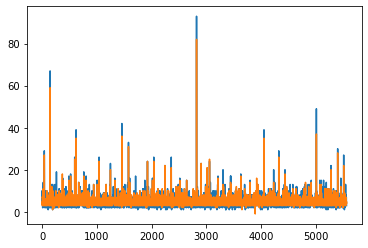

In [357]:
# plat prediction and ytest data
import matplotlib.pyplot as plt
plt.plot(ytest.to_numpy())
plt.plot(predict)

In [359]:
#now we are going to predict delivary date of the the sample_test data
ar_test_df= pd.read_csv("test_data_w_result.csv")

In [360]:
ar_test_df.head()

,Unnamed: 0,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,quantity,weight,weight_units,package_size,Distance,pay_to_acctt,record_number,payment_date,delivery_date
0,0,2,2.0,4,0.00,2,9,11,8.45,1,0,1,3,2531.894475,0,16377733,2019-12-02,2019-12-07
1,1,2,1.0,1,7.85,2,5,4,5.37,1,32,1,5,71.647965,2,16129562,2019-11-24,2019-11-28
2,2,1,3.0,0,3.75,3,5,0,8.00,1,4,1,5,1949.842421,2,15452689,2019-12-09,2019-12-14
3,3,2,1.0,0,0.00,3,5,7,6.25,1,0,1,4,3762.527510,2,16932805,2019-11-23,2019-11-28
4,4,1,2.0,1,18.00,2,5,22,50.00,1,32,1,5,1420.770599,3,16374203,2019-12-13,2019-12-19


In [361]:
tdf_record_number=ar_test_df.record_number
tdf_payment_date=ar_test_df.payment_date
ar_test_df.drop(['payment_date','record_number'],axis =1, inplace=True)

In [362]:
ar_test_df.drop(['delivery_date','Unnamed: 0'],axis =1, inplace=True)

In [363]:
# creating arkouda directory
def ak_create_akdict_from_df(df):
    akdict ={}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname]= ak.from_series(df[cname])
    return akdict

In [364]:
arkdict_test = ak_create_akdict_from_df(ar_test_df)

In [365]:
arkdict_test

{'b2c_c2c': array([2 2 1 ... 1 2 2]),
 'declared_handling_days': array([2 1 3 ... 1 1 3]),
 'shipment_method_id': array([4 1 0 ... 0 0 1]),
 'shipping_fee': array([0 7.8499999999999996 3.75 ... 3.75 3.3999999999999999 0]),
 'carrier_min_estimate': array([2 2 3 ... 3 3 2]),
 'carrier_max_estimate': array([9 5 5 ... 5 5 5]),
 'category_id': array([11 4 0 ... 7 16 1]),
 'item_price': array([8.4499999999999993 5.3700000000000001 8 ... 2.4900000000000002 1.9399999999999999 139.94999999999999]),
 'quantity': array([1 1 1 ... 1 1 1]),
 'weight': array([0 32 4 ... 0 0 32]),
 'weight_units': array([1 1 1 ... 1 1 1]),
 'package_size': array([3 5 5 ... 5 5 3]),
 'Distance': array([2531.8944748099057 71.647964561283416 1949.8424211179092 ... 287.54477284575006 4287.7256851183301 2519.615061958923]),
 'pay_to_acctt': array([0 2 2 ... 1 3 2])}

In [366]:
# feature engineering by arkouda
arkdict_test['carrier_mean'] = (arkdict_test['carrier_min_estimate']+arkdict_test['carrier_max_estimate'])/2
arkdict_test['whole_weight'] = arkdict_test['weight']*arkdict_test['weight_units']
arkdict_test['total_price'] = arkdict_test['item_price']*arkdict_test['quantity']
arkdict_test['exp_handling'] = arkdict_test['pay_to_acctt']+arkdict_test['declared_handling_days']

In [367]:
arkdict_test

{'b2c_c2c': array([2 2 1 ... 1 2 2]),
 'declared_handling_days': array([2 1 3 ... 1 1 3]),
 'shipment_method_id': array([4 1 0 ... 0 0 1]),
 'shipping_fee': array([0 7.8499999999999996 3.75 ... 3.75 3.3999999999999999 0]),
 'carrier_min_estimate': array([2 2 3 ... 3 3 2]),
 'carrier_max_estimate': array([9 5 5 ... 5 5 5]),
 'category_id': array([11 4 0 ... 7 16 1]),
 'item_price': array([8.4499999999999993 5.3700000000000001 8 ... 2.4900000000000002 1.9399999999999999 139.94999999999999]),
 'quantity': array([1 1 1 ... 1 1 1]),
 'weight': array([0 32 4 ... 0 0 32]),
 'weight_units': array([1 1 1 ... 1 1 1]),
 'package_size': array([3 5 5 ... 5 5 3]),
 'Distance': array([2531.8944748099057 71.647964561283416 1949.8424211179092 ... 287.54477284575006 4287.7256851183301 2519.615061958923]),
 'pay_to_acctt': array([0 2 2 ... 1 3 2]),
 'carrier_mean': array([5.5 3.5 4 ... 4 4 3.5]),
 'whole_weight': array([0 32 4 ... 0 0 32]),
 'total_price': array([8.4499999999999993 5.3700000000000001 8 .

In [368]:
# back to arkouda to dataframe
akdf_test = pd.DataFrame({col: a.to_ndarray() for col, a in arkdict_test.items()})

In [369]:
akdf_test.drop(['carrier_min_estimate','carrier_max_estimate','item_price','quantity','weight','weight_units'], axis=1,inplace=True)

akdf_test.drop(['declared_handling_days'],axis=1,inplace=True)

In [370]:
akdf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14792 entries, 0 to 14791
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   b2c_c2c             14792 non-null  int64  
 1   shipment_method_id  14792 non-null  int64  
 2   shipping_fee        14792 non-null  float64
 3   category_id         14792 non-null  int64  
 4   package_size        14792 non-null  int64  
 5   Distance            14792 non-null  float64
 6   pay_to_acctt        14792 non-null  int64  
 7   carrier_mean        14792 non-null  float64
 8   whole_weight        14792 non-null  int64  
 9   total_price         14792 non-null  float64
 10  exp_handling        14792 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 1.2 MB


In [371]:
import datetime

In [372]:
test_predict=model.predict(akdf_test).round(0)

In [373]:
npr = pd.Series(test_predict)

In [374]:
tdf_payment_date


0        2019-12-02
1        2019-11-24
2        2019-12-09
3        2019-11-23
4        2019-12-13
            ...    
14787    2019-11-30
14788    2019-12-08
14789    2019-12-06
14790    2019-11-09
14791    2019-11-18
Name: payment_date, Length: 14792, dtype: object

In [375]:
tdf_payment_date=pd.to_datetime(tdf_payment_date)

In [376]:
# # calculating delivery date for sample test dataset
test_deivery_date =pd.Series([])

for i in range(len(tdf_payment_date)):
    
    nextdate = tdf_payment_date[i] + datetime.timedelta(days=npr[i])
    nextdate=pd.Series([nextdate])
    test_deivery_date=test_deivery_date.append(nextdate,ignore_index=True)

<ipython-input-376-fc1a9ab07469>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_deivery_date =pd.Series([])


In [377]:
test_deivery_date

0       2019-12-07
1       2019-11-28
2       2019-12-14
3       2019-11-28
4       2019-12-19
           ...    
14787   2019-12-05
14788   2019-12-14
14789   2019-12-10
14790   2019-11-15
14791   2019-11-23
Length: 14792, dtype: datetime64[ns]

In [378]:
record_no_n_deivery_date=pd.DataFrame()

In [379]:
record_no_n_deivery_date['record_number']=tdf_record_number

In [380]:
record_no_n_deivery_date['deivery_date']=test_deivery_date

In [381]:
record_no_n_deivery_date.head()

,record_number,deivery_date
0,16377733,2019-12-07
1,16129562,2019-11-28
2,15452689,2019-12-14
3,16932805,2019-11-28
4,16374203,2019-12-19


In [382]:
record_no_n_deivery_date.to_csv('deivery_date_testdata.csv', encoding='utf-8', index=False)